# More Dilution Experiment Controls 

In [569]:
import numpy as np
import matplotlib.pyplot as plt
import mscl.plotting
import mscl.process
import mscl.stats
import pandas as pd
import scipy.optimize
import glob
import matlab.engine as matlab
colors = mscl.plotting.set_plotting_style()
eng = matlab.start_matlab()
%matplotlib inline

## The Experiment 

The goal of this noteboook is to perform some more troubleshooting with the dilution experiment using an experimental sample which had the 20ng/mL aTc removed via washing and one without any washing at all. I also look at data from an experiment in which here was no induction of the genetic circuit at all. 

For the washing experiment (20180105), the positions corresponded to the following samples:

| Position | Sample |
|---|---|
|0 - 9 | 20 ng/mL aTc washed 3x |
|10 - 19| 20 ng/mL aTc no wash |

Below, I will read in these cell files and separate them by these two experiments, as well as sload teh autofluorescence information

###  Loading the data

In [570]:
# Define the root directory for the data. 
root_dir = '../../data/images/20180105_sfGFP_20ngmL_dilution/'

# Grab all of the xy directories.
positions = glob.glob('{0}growth/xy*'.format(root_dir))

# Set up a storage vector for the dataframes.
dfs = []

# Loop through each position and process teh cell files.
for i, p in enumerate(positions):
    pos = int(p.split('/')[-1].split('xy')[1])
    # Grab all of the cell files.
    cell_files = glob.glob('{0}/cell/*.mat'.format(p))
   
    if pos <= 9:
        wash = True
    else:
        wash = False
    # Extract the data. 
    _df = mscl.process.parse_cell_files(cell_files, eng, add_props={'position': pos, 'wash': wash})


    # Add to the storage list.
    dfs.append(_df)
    
# Concatenate into a single dataframe. 
df = pd.concat(dfs, ignore_index=True)

We will also load teh autofluorescence data and the standard candle data, MLG910 

In [571]:
# Grab all autofluorescence files.
positions = glob.glob('{0}/autofluorescence/xy*'.format(root_dir))
dfs = []
for i, p in enumerate(positions):
    cell_files = glob.glob('{0}/cell/*.mat'.format(p))
    _df = mscl.process.parse_cell_files(cell_files, eng, excluded_props=['birth', 'death', 'death_fluo', 
                                                                        'daughter_1_ID', 'daughter_2_ID',
                                                                        'ID', 'motherID', 'death_area',
                                                                        'num_exposures'])
    dfs.append(_df)
auto = pd.concat(dfs, ignore_index=True)

# Grab all MLG910 images.
positions = glob.glob('{0}/mlg910/xy*'.format(root_dir))
dfs = []
for i , p in enumerate(positions):
    cell_files = glob.glob('{0}/cell/*.mat'.format(p))
    _df = mscl.process.parse_cell_files(cell_files, eng, excluded_props=['birth', 'death', 'death_fluo', 
                                                                        'daughter_1_ID', 'daughter_2_ID',
                                                                        'ID', 'motherID', 'death_area',
                                                                        'num_exposures'])
    dfs.append(_df)
    
mlg910 = pd.concat(dfs, ignore_index=True)

### Examining the distributions

It would be informative to see the distributions of the washed and unwashed sample at the first frame compared to the last frame. The distribution of the autofluorescence sample will also be overlaid.  

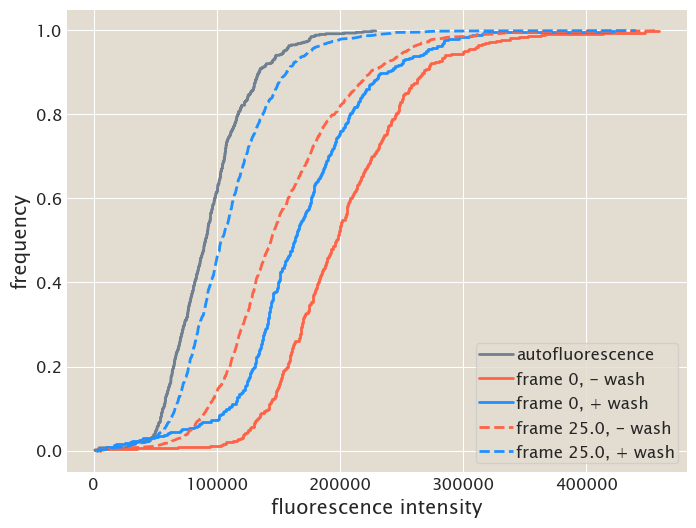

In [572]:
# Narrow the data frame to only the birth cells.
founders = df[df['birth']==1]

# Find the max death frame number.
final_frame = np.max(df['death'].unique())
finalists = df[df['death']==final_frame]

# Group by wash state.
founder_grouped = founders.groupby('wash')
finalists_grouped = finalists.groupby('wash')

# Set up the figure canvas.
fig, ax = plt.subplots(1, 1, sharex=True)
ax.set_ylabel('frequency')
ax.set_xlabel('fluorescence intensity')


# Define the color palette.
colors = {True:'dodgerblue', False:'tomato'}
labels = {True: '+ wash', False:'- wash'}

# Plot the autofluorescence distribution on each plot first.
auto_x, auto_y = mscl.stats.ecdf(auto['birth_fluo'])
ax.step(auto_x, auto_y, '-', color='slategray', label='autofluorescence')

# Plot the founders first.
for g, d in founder_grouped:
    color = colors[g]
    x, y = mscl.stats.ecdf(d['death_fluo'])
    ax.step(x, y, '-', color=color, label='frame {0}, {1}'.format(0, labels[g]))

for g, d in finalists_grouped:
    color = colors[g]
    x, y = mscl.stats.ecdf(d['death_fluo'])
    ax.plot(x, y, '--', color=color, label='frame {0}, {1}'.format(final_frame, labels[g]))
 
ax.legend()


This makes some sense with what we would expect, although I would expect the frame 0 +/- wash to be more similar to each other. This may be due to the autofluorescence of the aTc. After a long period of growth, the sample with washing much more closely resembles the autofluorescence distribution whereas the sample without washing is still quite a bit above. To be completely sure of this effect, however, we must correct for photobleaching. Previously, I've done this for individual division events and not entire lineages. Here, I try to correct for photobleaching in an entire lineage. 

##  Correcting Photobleaching in Lineages

I've already performed the best-fit of a photobleaching curve for some constitutively expressing cells. Below, I load teh decay constants from this fit.  

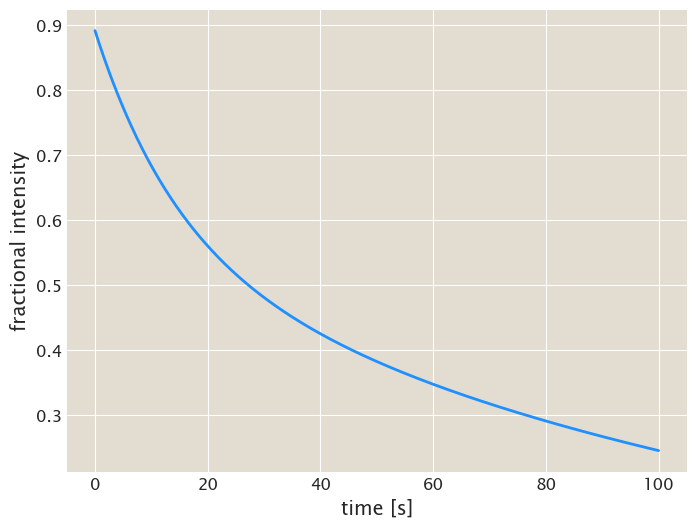

In [573]:
# Load the photobleaching decay constants and extract them.
bleaching = pd.read_csv('../../code/dilution_processing/20180105_sfGFP_20ngmL_dilution/output/20180105_sfGFP_20ngmL_bleaching_constants.csv')
bg, I_0_1, tau_1, I_0_2, tau_2 = bleaching.values[0]

# Plot the curve.
time_range = np.linspace(0, 100, 500)
theo = bg + beta_1 * np.exp(-time_range / tau_1) + beta_2 * np.exp(-time_range / tau_2)
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('fractional intensity')
_ = ax.plot(time_range, theo, '-', color='dodgerblue')

To perform the 'proper' correction, I will have to chase down each individual lineage, total the number of exposures, and calculate the fractional representation. To test this method, I've isolated a single position from one of the washing samples. 

In [574]:
# Isolate a single position
pos =1 
pos_df = df[df['position']==pos].copy()

# Add a cumulative exposures column.
pos_df.loc[:, 'cumu_exp'] = 0

# Get a list of all of the lineage founding cells.
mothers = pos_df[pos_df['motherID']==0]['ID'].values 
it = 0
while (np.min(pos_df['cumu_exp'].values) == 0) & (it < 1000):
    next_mothers = []
    # Loop through each mother. 
    for i, m in enumerate(mothers):
        # get the sub dataframe.
        sub_df = pos_df[pos_df['ID']==m]
    
        # Get a list of the daughters.
        daughters = sub_df[['daughter_1_ID', 'daughter_2_ID']].values[0]
    
        # Set up the extenuating cases of the mother not dividing. 
        if sub_df['motherID'].values[0] == 0:
                pos_df.loc[pos_df['ID']==m, 'cumu_exp'] = sub_df['num_exposures'].values[0]
                
        for d in daughters[np.isnan(list(daughters)) == False]: 
            next_mothers.append(d)
            # Adjust the cumulative exposures
            pos_df.loc[pos_df['ID']==d, 'cumu_exp'] = pos_df[pos_df['ID']==m]['cumu_exp'].values[0] +\
                                pos_df[pos_df['ID']==d]['num_exposures'].values[0]
    
    mothers = next_mothers
    it += 1  

Now, using the cumulative number of exposures, the "actual" fluorescence can be calculated. Our model for photobleaching is a biexponential decay of the form, 

$$
I(t) = \beta + I_0^{(1)} e^{-t / \tau_1} + I_0^{(2)} e^{-t / \tau_2},
$$

where $I(t)$ is the fractional intensity of the maximum. To correct the fluorescence intensity, we simply need to calculate the fractional intensity and divide the measured intensity by this number. First, we will have to correct for the autofluorescence by subtracting the mean autofluorescence pixel intensity multiplied by the cell area. 


In [575]:
# Compute the mean autofluorescence value.
mean_auto = np.mean(auto['birth_fluo'] / auto['birth_area'])

# Subtract it from the dataframe.
pos_df.loc[:, 'sub_fluo'] = pos_df.loc[:, 'death_fluo'] - (mean_auto * pos_df.loc[:, 'death_area'])

In [576]:
def corrected_fluorescence(num_exp, val, exposure=0.1):
    time = num_exp * exposure
    frac = bg + I_0_1 * np.exp(-time / tau_1) + I_0_2 * np.exp(-time / tau_2)
    return val / frac

In [577]:
# Compute the corrected fluorescence and include it in the DataFrame.
corrected = corrected_fluorescence(pos_df['cumu_exp'], pos_df['sub_fluo'])
pos_df.loc[:, 'corrected_fluorescence'] = corrected

A good way to check that this worked is by plotting the conservation of fluorescence. We should be able to check that the sum of any two daughters should approximately match the mother fluorescence.  

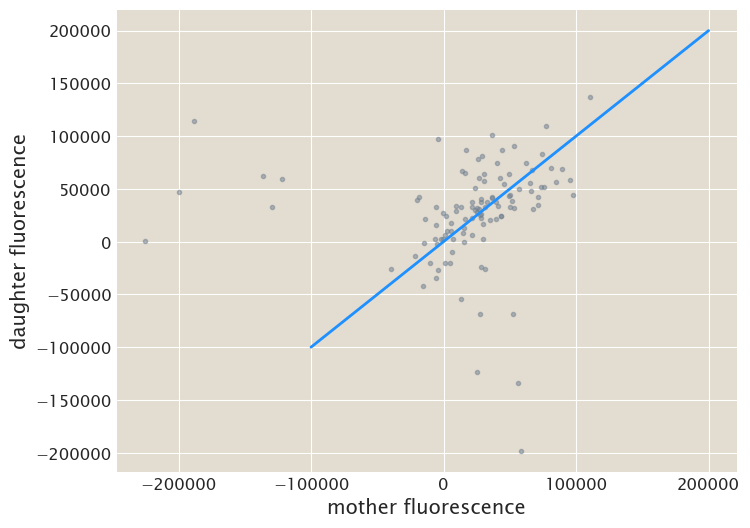

In [578]:
# Group by the mother ID
grouped = pos_df.groupby(['motherID'])
mother_int = []
daughter_int = []

# Iterate through the grouped dataframe and update the values.
for g, d in grouped:
    # Make sure there are two daughters. 
    if len(d) == 2:
        daughter_int.append(np.sum(d['corrected_fluorescence'].values))
        mother_int.append(pos_df[pos_df['ID']==g]['corrected_fluorescence'].values[0])
    
# Plot the data and prediction.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('mother fluorescence')
ax.set_ylabel('daughter fluorescence')
_ = ax.plot(mother_int, daughter_int, '.', color='slategray', alpha=0.5)
int_range = np.linspace(-100000, 200000, 300)
_ = ax.plot(int_range, int_range, '-', color='dodgerblue')

Aside from the problem of the negative values, this scheme seems to work for correcting for photobleaching as the data points are quite obviously positively linearly correlated. Below, we run this whole procedure over the entire dataframe.  

In [579]:
# Group the dataframe by position.
grouped = df.groupby('position')
dfs = []

for g, data in grouped:
    # Isolate a single position 
    data = data.copy()
    
    # Add a cumulative exposures column.
    data.loc[:, 'cumu_exp'] = 0

    # Get a list of all of the lineage founding cells.
    mothers = data[data['motherID']==0]['ID'].values 
    it = 0
    while (np.min(data['cumu_exp'].values) == 0) & (it < 1000):
        next_mothers = []
        # Loop through each mother. 
        for i, m in enumerate(mothers):
            # get the sub dataframe.
            sub_df = data[data['ID']==m]
    
            # Get a list of the daughters.
            daughters = sub_df[['daughter_1_ID', 'daughter_2_ID']].values[0]
    
            # Set up the extenuating cases of the mother not dividing. 
            if sub_df['motherID'].values[0] == 0:
                    data.loc[data['ID']==m, 'cumu_exp'] = sub_df['num_exposures'].values[0]

            try:
                _daughters = daughters[np.isnan(list(daughters)) == False]
            except:
                _daughters = [_d for _d in daughters if _d != None]
            for d in _daughters: 
                next_mothers.append(d)
                # Adjust the cumulative exposures
                data.loc[data['ID']==d, 'cumu_exp'] = data[data['ID']==m]['cumu_exp'].values[0] +\
                                data[data['ID']==d]['num_exposures'].values[0]
    
        mothers = next_mothers
        it += 1  
    dfs.append(data)

exp_df = pd.concat(dfs, ignore_index=True)

Now, we correct for autofluorescence and for photobleaching. 

In [580]:
# Subtract autofluorescence
exp_df.loc[:, 'sub_fluo'] = exp_df.loc[:, 'death_fluo'] - (mean_auto * exp_df.loc[:, 'death_area'])

# Correct for photobleaching.
corrected = corrected_fluorescence(exp_df['cumu_exp'], exp_df['sub_fluo'])
exp_df.loc[:, 'corrected_fluo'] = corrected

Now we can perform another sanity check by testing the conservation of fluorescence. For the case of production, the fluorescence should not be conserved where as it should for the washed samples. 

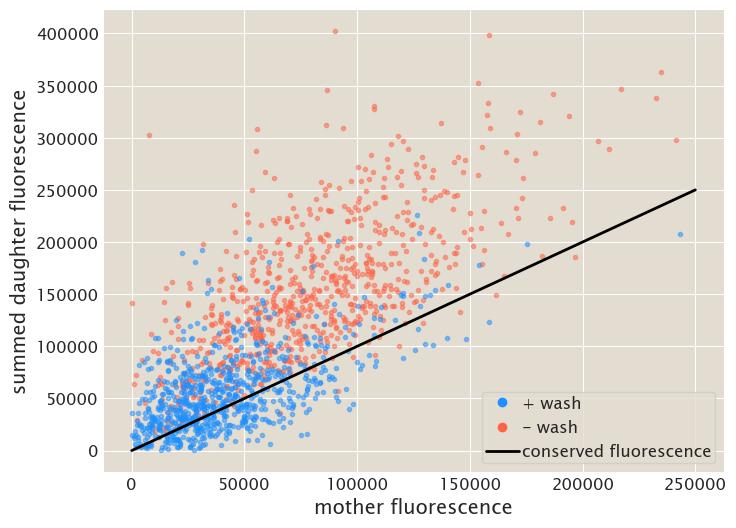

In [581]:
# Set up the figure canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('mother fluorescence')
ax.set_ylabel('summed daughter fluorescence')
_ = ax.plot([], [], 'o', color='dodgerblue', label='+ wash')
_ = ax.plot([], [], 'o', color='tomato', label='- wash')

# Group by sample ID
grouped = exp_df.groupby(['wash', 'position', 'motherID'])
colors = {True: 'dodgerblue', False: 'tomato'}
for g, d in grouped:  
    # Ensure the data only has two daughters.
    if len(d) == 2:
        mother = exp_df[(exp_df['position']==g[1]) & (exp_df['ID']==g[2])]['corrected_fluo']
        
        daughter = np.sum(d['corrected_fluo'].values)
        if (mother > 0).all() & (daughter > 0).all():
            _ = ax.plot(mother, daughter, '.', color=colors[g[0]], alpha=0.5) 

# Plot the prediction.
int_range = np.linspace(0, 250000, 300)
_ = ax.plot(int_range, int_range, color='k', label='conserved fluorescence')
_ = ax.legend()

Note that nearly the entirety of the no wash samples lie above the conservation of fluorescence. That strongly shows that production is still occuring. The fluorescence appears to be conserved for the samples that were reliably washed, although there is still a high degree of variance. This is partially due to the wide distribution of autofluorescence in the GFP channel. 

## Re-examining the distributions 

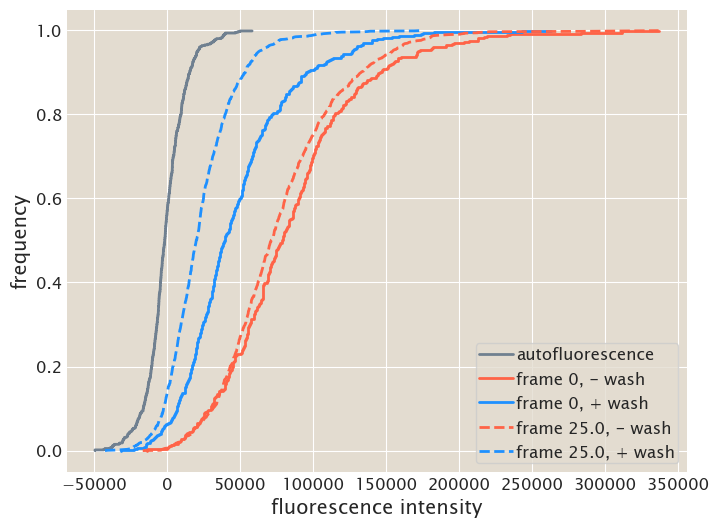

In [545]:
# Narrow the data frame to only the birth cells.
founders = exp_df[exp_df['birth']==1]

# Find the max death frame number.
final_frame = np.max(exp_df['death'].unique())
finalists = exp_df[exp_df['death']==final_frame]

# Group by wash state.
founder_grouped = founders.groupby('wash')
finalists_grouped = finalists.groupby('wash')

# Set up the figure canvas.
fig, ax = plt.subplots(1, 1, sharex=True)
ax.set_ylabel('frequency')
ax.set_xlabel('fluorescence intensity')

# Plot the autofluorescence distributions.
auto.loc[:, 'sub'] = auto.loc[:, 'birth_fluo'] - (mean_auto * auto.loc[:, 'birth_area'])
x, y = mscl.stats.ecdf(auto['sub'])
ax.step(x, y, '-', color='slategray', label='autofluorescence')
# Define the color palette.
colors = {True:'dodgerblue', False:'tomato'}
labels = {True: '+ wash', False:'- wash'}

# Plot the founders first.
for g, d in founder_grouped:
    color = colors[g]
    x, y = mscl.stats.ecdf(d['corrected_fluo'])
    ax.step(x, y, '-', color=color, label='frame {0}, {1}'.format(0, labels[g]))

for g, d in finalists_grouped:
    color = colors[g]
    x, y = mscl.stats.ecdf(d['corrected_fluo'])
    ax.plot(x, y, '--', color=color, label='frame {0}, {1}'.format(final_frame, labels[g]))
 
ax.legend()


This now jibes quite well with our expectation given the description of the experiment. The strain which was washed shows a leftward shift in the intensity distribution from the very first frame to the last frame. However, the distribution of the strain that was not washed stays about the same from the very first frame to the last. 

## Estimating the Calibration Factor

It will be instructive to estiamte the calibration factor for both of these samples. Below, we iterate through the two samples and compute the necessary information.  

In [546]:
# Set up storage lists
i_1, i_2 = [[], []], [[], []]
sq_diff, mother = [[], []], [[], []]
index = {True: 0, False: 1}

# Group the data by wash, position, and mother ID. 
positive = exp_df[(exp_df['corrected_fluo'] > 0)]
grouped = positive.groupby(['wash', 'position', 'motherID'])
for g, d in grouped:
    # Ensure there are only two daughter cells
    try:
        if len(d) == 2:
            m = positive[(positive['position']==g[1]) & (positive['ID']==g[2])]['corrected_fluo']
            daughters = d['corrected_fluo'].values
        
            if (m >= 0).all() & (daughters >= 0).all():
                i_1[index[g[0]]].append(daughters[0])
                i_2[index[g[0]]].append(daughters[1])
                mother[index[g[0]]].append(m.values[0])
                sq_diff[index[g[0]]].append((daughters[0] - daughters[1])**2)
    except: 
        pass
    
i_1 = [np.array(i_1[0]), np.array(i_1[1])]
i_2 = [np.array(i_2[0]), np.array(i_2[1])]
sq_diff = [np.array(sq_diff[0]), np.array(sq_diff[1])]
mother = [np.array(mother[0]), np.array(mother[1])]

In [547]:
def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    
    # Ensure that the intensity values are not negative.
    if (I_1 < 0).any() or (I_2 < 0).any():
        return ValueError('I_1 and I_2 must be positive.')
    
    # Ensure that alpha is positive.
    if alpha < 0:
        return -np.inf
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha 
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
    
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
        
    return prefactor * lp

In [548]:
# Perform the parameter estimation.
wash_popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(i_1[0], i_2[0], 
                                                                              (i_1[0] + i_2[0]), True))
no_wash_popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(np.array(i_1[1]), np.array(i_2[1]),
                                                                                np.array(i_1[1]) + np.array(i_2[1]), True))
print('The calibration factor for the washed sample is {0:0.1f} and for the unwashed\nsample is {1:0.1f} a.u. per molecule.'.format(wash_popt.x,
                                                                                                                         no_wash_popt.x))

The calibration factor for the washed sample is 7746.7 and for the unwashed
sample is 9261.6 a.u. per molecule.


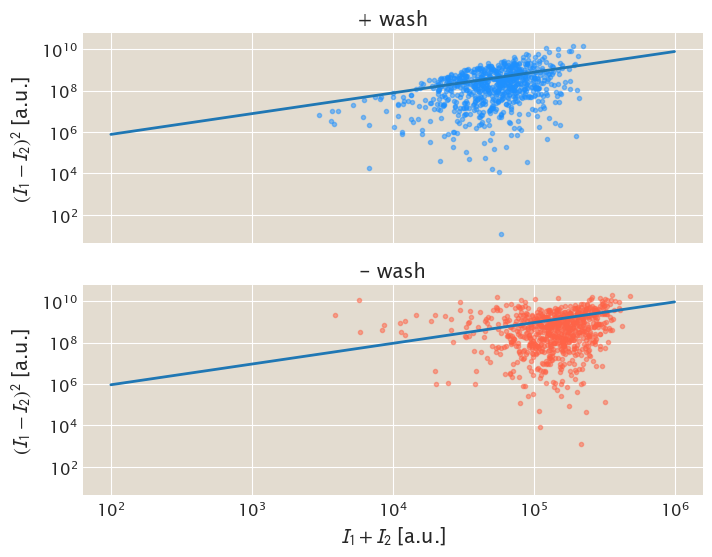

In [584]:
# Generate the scatter plot.
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].set_ylabel('$(I_1 -I_2)^2$ [a.u.]')
ax[1].set_ylabel('$(I_1 -I_2)^2$ [a.u.]')
ax[1].set_xlabel('$I_1 + I_2$ [a.u.]')
ax[0].set_title('+ wash')
ax[1].set_title('- wash')
for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')

I_tot_range = np.logspace(2, 6, 500)
_ = ax[0].plot(np.array(i_1[0]) + np.array(i_2[0]), (np.array(i_1[0]) - np.array(i_2[0]))**2, '.', color='dodgerblue', alpha=0.5)
_ = ax[1].plot(np.array(i_1[1]) + np.array(i_1[1]), (np.array(i_1[1]) - np.array(i_2[1]))**2, '.', color='tomato', alpha=0.5)
_ = ax[0].plot(I_tot_range, wash_popt.x * I_tot_range)
_ = ax[1].plot(I_tot_range, no_wash_popt.x * I_tot_range)

While these values seem to agree with the data, they seem rather high. For example, we know that MLG910 harvested at an OD of 0.3 in M9 + 0.5% glucose should have a channel number close to 350. 

In [550]:
# Find the mean mlg910 data. 
mlg910.loc[:, 'sub'] = (mlg910.loc[:, 'birth_fluo'] * 4) - (4 * mean_auto * mlg910.loc[:, 'birth_area'])
mean_mlg910 = np.mean(mlg910['sub'])
wash_chan = 5 * wash_popt.x
print('Using the calibration factor {0:0.1f}, the channel copy number for MLG910 is {1:0.1f}'.format(wash_popt.x, mean_mlg910 /  wash_chan))

Using the calibration factor 7746.7, the channel copy number for MLG910 is 13.6


Obviously, something is wrong here as this doesn't make much sense being off by an order of magnitude. 

## Estimation by binning

To see if it's a problem with my deterministic approach, below I try to estimate the calibration factor by binning the data by a number of events per bin. First, I write a function which bins the data by a given event size.  

In [592]:
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='I_tot')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_I_tot = [data.iloc[bins[i-1]:bins[i]+1]['I_tot'].mean() for i in range(1, len(bins))] 
    return [np.array(mean_sq_diff), np.array(mean_I_tot)] 

In [638]:
def log_posterior(alpha, sq_diff, summed_int, neg=True):
    """
    Computes the log posterior distribution for linear regression.
    
    Parameters
    ----------
    alpha : float
        Value of the calibration factor in arbitrary units.
    I_tot : pandas DataFrame or array
        The summed value of the daughter intensities.
    neg: bool
        If True, the negative of the log posterior is returned. Defaults is True. 
    Returns
    --------
    lp : 1d-array
        The value of the log posterior at a given alpha. 

    """
    k = len(summed_int)
    lp = -(k/2) * np.log(np.sum((sq_diff - alpha * summed_int)**2))
    if neg is True:
        prefactor = -1
    else:
        prefactor = 1
    return prefactor * lp

Now, I will bin the washed data by a fixed number of events per bin.  

In [639]:
# Set binning size. 
bin_size = 50

# Set up the dataframe. 
binning_df = pd.DataFrame(np.array([i_1[0], i_2[0], i_1[0] + i_2[0]]).T, columns=['I_1', 'I_2', 'I_tot'])

binned_sqdiff, binned_itot = binning_mean(binning_df, bin_size, sort_values=True)

In [640]:
# Perform the fit.
popt = scipy.optimize.minimize_scalar(log_posterior, args=(binned_sqdiff, binned_itot))
alpha_fit = popt.x
print('Best-fit for α is {0:0.0f} a.u.'.format(popt.x))

Best-fit for α is 11037 a.u.


In [641]:
popt

     fun: 313.09932423344412
    nfev: 9
     nit: 8
 success: True
       x: 11036.886561244241

In [642]:
popt.x

11036.886561244241

Again, this is much larger thant I would have näively thought. Let's take a look at the fit.  

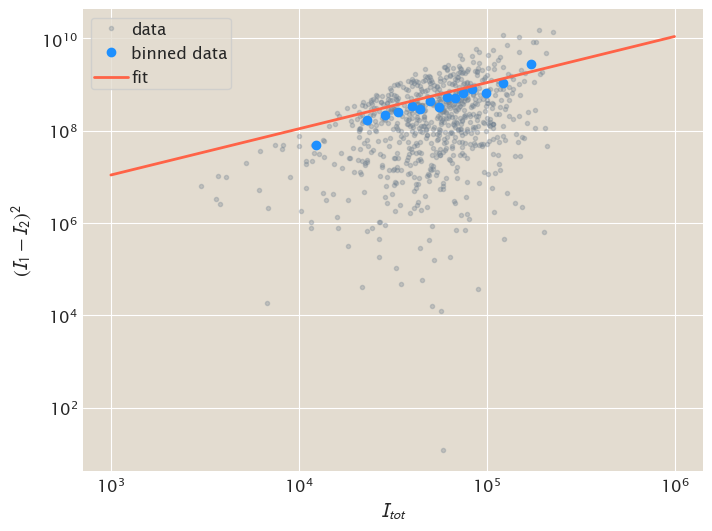

In [646]:
# Plot the data and the bins.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$')
ax.set_ylabel('$(I_1 - I_2)^2$')

# Plot the things.
_ = ax.plot(binning_df['I_tot'], (binning_df['I_1'] - binning_df['I_2'])**2, '.', color='slategray',
       alpha=0.3, label='data')
_ = ax.plot(binned_itot, binned_sqdiff, 'o', color='dodgerblue', label='binned data')

# Compute the fit.
i_tot_range = np.logspace(3, 6, 300)
fit = alpha_fit * i_tot_range
_ = ax.plot(i_tot_range, fit, '-', color='tomato', label='fit')
_ = ax.legend()

That looks like a pretty good fit. Let's try changing the event binning size.

In [647]:
# set the binning range. 
bin_range = np.arange(1, len(binning_df['I_1']), 1)
alpha = []
for b in bin_range:
    y, x = binning_mean(binning_df, b, sort_values=True)
    popt = scipy.optimize.minimize_scalar(log_posterior, args=(y, x))
    alpha.append(popt.x)

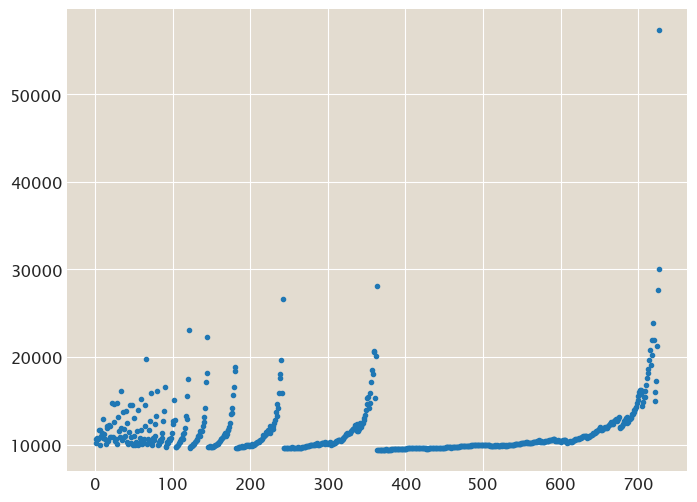

In [648]:
# plot the alpha. 
fig, ax = plt.subplots(1, 1)
_ = ax.plot(bin_range, alpha, '.')
